# Explore the error suppression and error mitigation options available with the Estimator primitive from Qiskit Runtime

We will use the following error suppression and mitigation options:

    -Dynamical Decoupling
    -Measurement and error mitigation
    -Gate twirling
    -Zero-noise extrapolation (ZNE)

# Step 1: Design

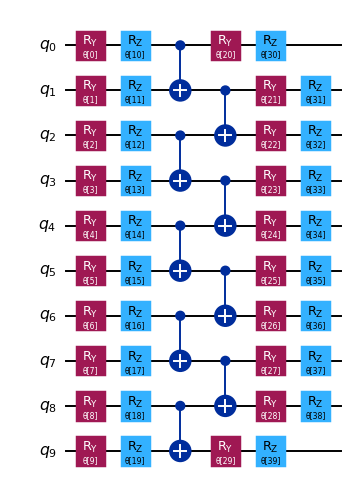

In [20]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 10
reps = 1

circuit = EfficientSU2(n_qubits, entanglement=["pairwise"], reps=reps)

circuit.decompose().draw("mpl", scale=0.7)

In [21]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=n_qubits)

At this point, you could proceed to run your circuit and measure the observable. However, you also want to compare the output of the quantum device with the correct answer - that is, the theoretical value of the observable, if the circuit had been executed without error. For small quantum circuits you can calculate this value by simulating the circuit on a classical computer, but this is not possible for larger, utility-scale circuits. You can work around this issue with the **mirror circuit** technique (also known as "compute-uncompute"), which is useful for benchmarking the performance of quantum devices.

### Mirror circuit

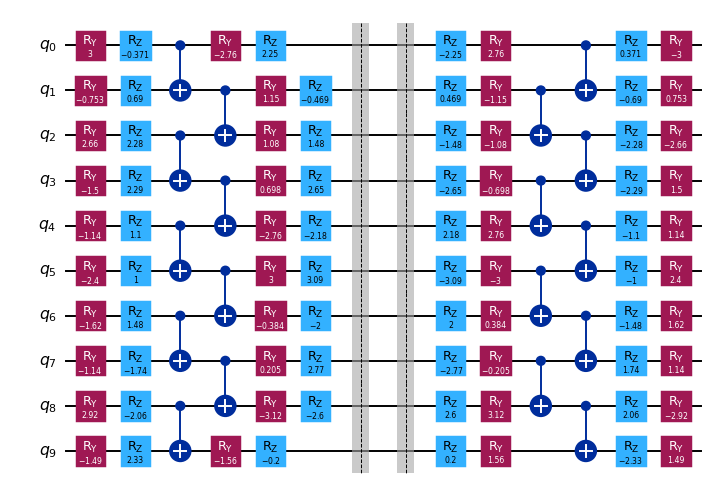

In [22]:
import numpy as np
from qiskit.circuit.library import UnitaryOverlap

# Generate random parameters
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)

# Assign the parameters to the circuit
assigned_circuit = circuit.assign_parameters(params)

# Add a barrier to prevent circuit optimization of mirrored operators
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

mirror_circuit.decompose().draw("mpl", scale=0.7)

# Step 2: Optimise

You must optimize your circuit before running it on hardware. This process involves a few steps:

    -Pick a qubit layout that maps the virtual qubits of your circuit to physical qubits on the hardware.
    -Insert swap gates as needed to route interactions between qubits that are not connected.
    -Translate the gates in your circuit to Instruction Set Architecture (ISA) instructions that can directly be executed on the hardware.
    -Perform circuit optimizations to minimize the circuit depth and gate count.

133


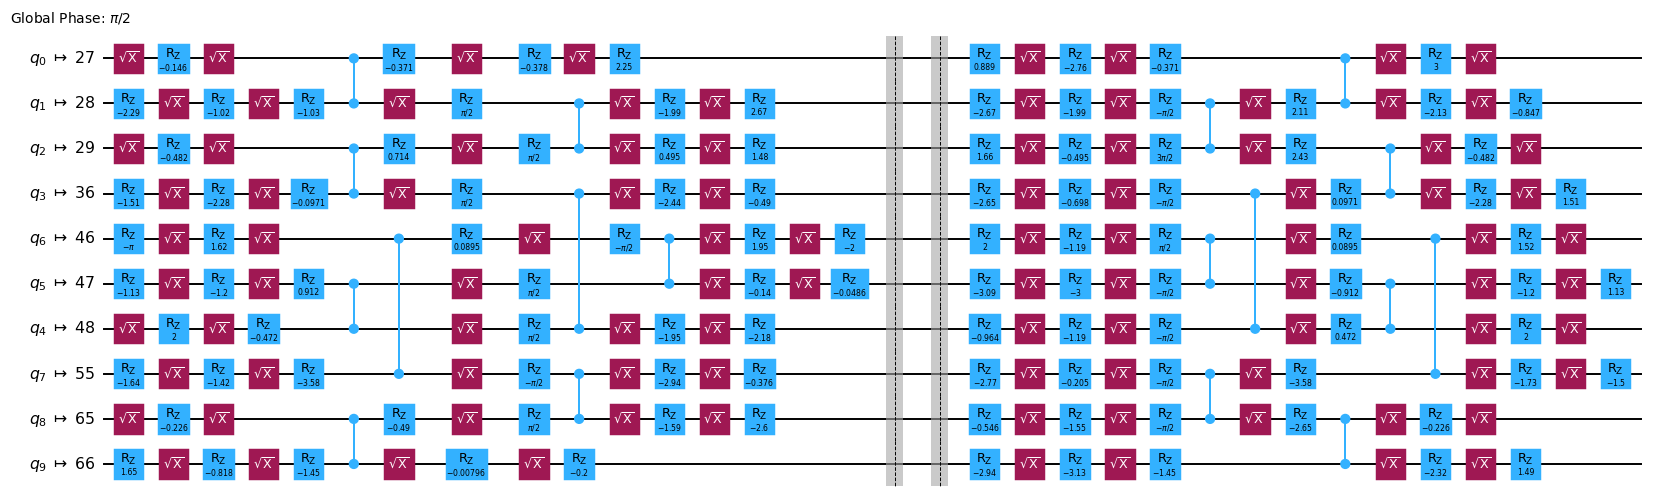

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

backend = service.least_busy(min_num_qubits=127)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_circuit)

isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)

In [7]:
isa_observable = observable.apply_layout(isa_circuit.layout)

print("Original observable:")
print(observable)
print()
print("Observable with layout applied:")
print(isa_observable)

Original observable:
SparsePauliOp(['ZIIIIIIIII'],
              coeffs=[1.+0.j])

Observable with layout applied:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])


# Step 3: Execute with Estimator primitive

In [36]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    # Set number of shots
    estimator.options.default_shots = 100_000
    # Disable runtime compilation and error mitigation
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add dynamical decoupling (DD)
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XpXm"
    job1 = estimator.run([pub])
    jobs.append(job1)

    # Add readout error mitigation (DD + TREX)
    estimator.options.resilience.measure_mitigation = True
    job2 = estimator.run([pub])
    jobs.append(job2)

    # Add gate twirling (DD + TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
    job3 = estimator.run([pub])
    jobs.append(job3)

    # Add zero-noise extrapolation (DD + TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job4 = estimator.run([pub])
    jobs.append(job4)

qiskit_runtime_service.check_pending_jobs:WARNING:2025-03-11 15:57:12,930: The pending jobs limit has been reached. Waiting for job <RuntimeJob('cz84yg2b7tt0008fvbxg', 'estimator')> to finish before submitting the next one.
qiskit_runtime_service.check_pending_jobs:WARNING:2025-03-11 15:58:26,211: The pending jobs limit has been reached. Waiting for job <RuntimeJob('cz84ygtqadq0008by7yg', 'estimator')> to finish before submitting the next one.


In [ ]:
jobs_without_error = [job0, job1, job2, job4]

# Step 4: Analise (measured expectation values)

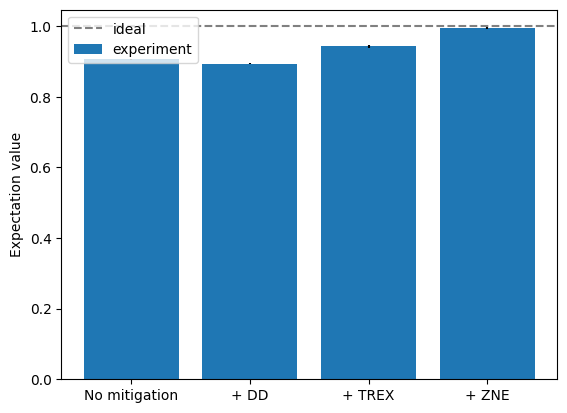

In [59]:
import matplotlib.pyplot as plt

# Retrieve the job results
results = [job.result() for job in jobs_without_error]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])
standard_errors = np.array([float(pub_result.data.stds) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ DD", "+ TREX", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, yerr=standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()

# Scale it up

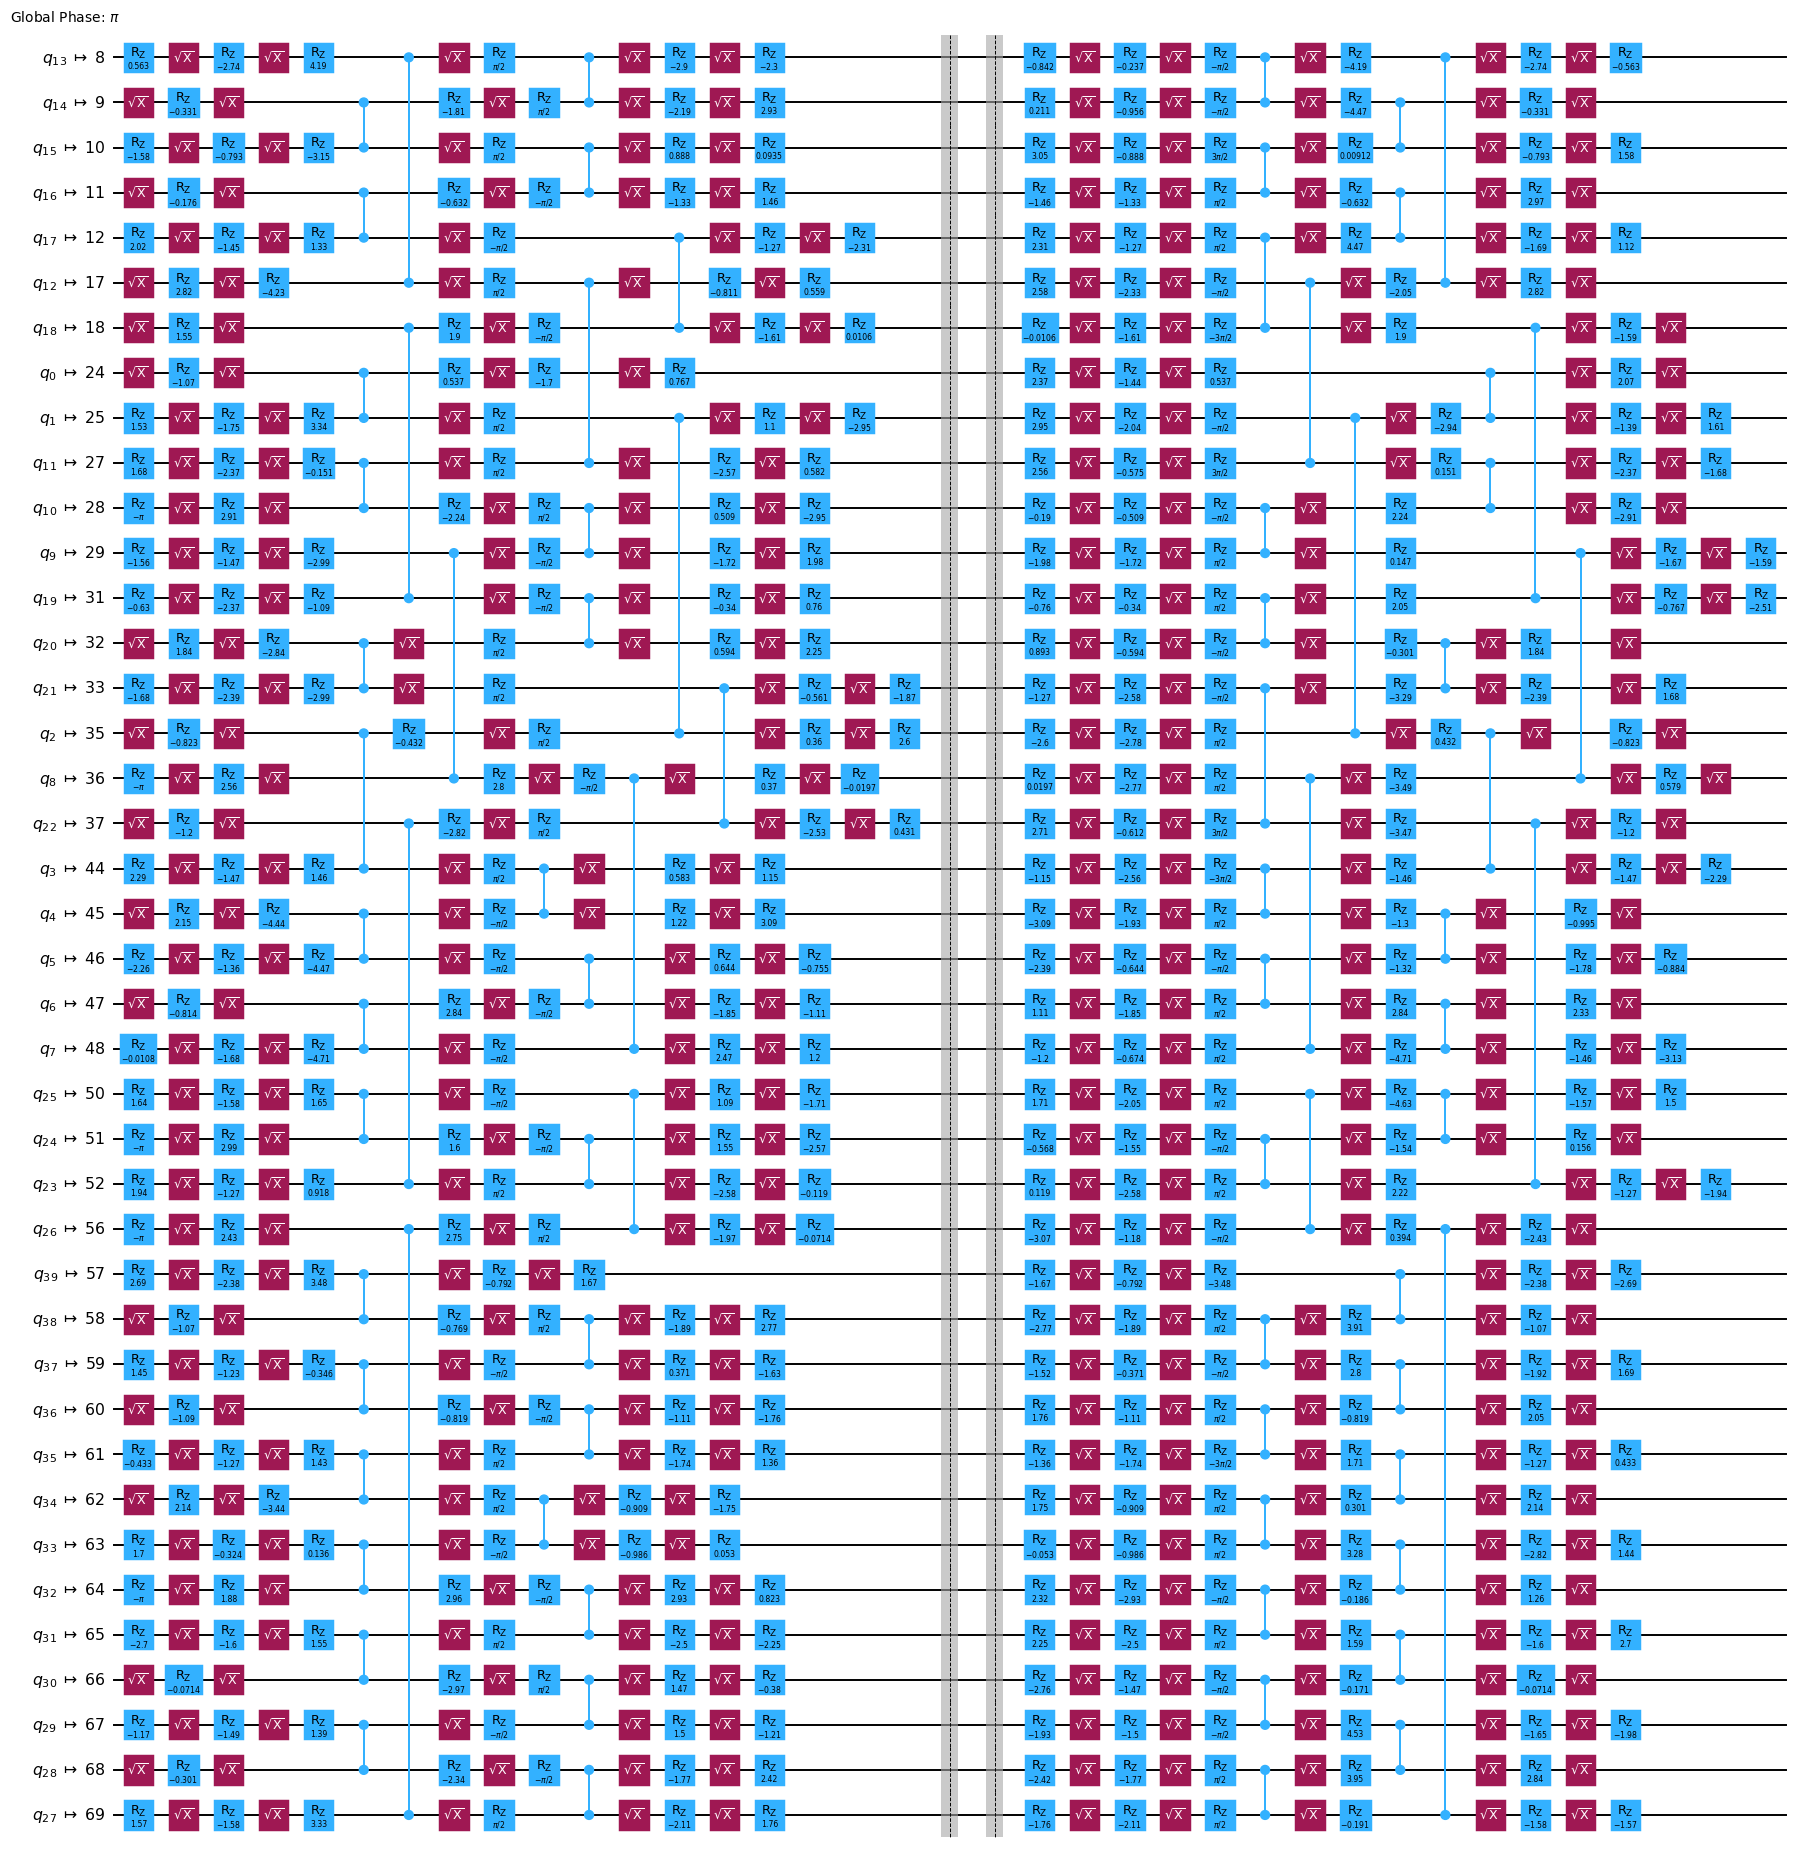

In [27]:
n_qubits = 40
reps = 1

# Construct the circuit and observables
circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)
observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=n_qubits)

# Assign parameters to circuit
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)
assigned_circuit = circuit.assign_parameters(params)
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

# Transpile mirror circuit
isa_circuit = pass_manager.run(mirror_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)

# Try here a fake provider

C:\Users\Mikel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction QId_d0 on channel d0 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
C:\Users\Mikel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry is ignored: Instruction QId_d1 on channel d1 is not found in Qiskit namespace. This instruction cannot be deserialized..
  warnings.warn(
C:\Users\Mikel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\pulse\calibration_entries.py:337: UserWarning: Pulse calibration cannot be built and the entry i

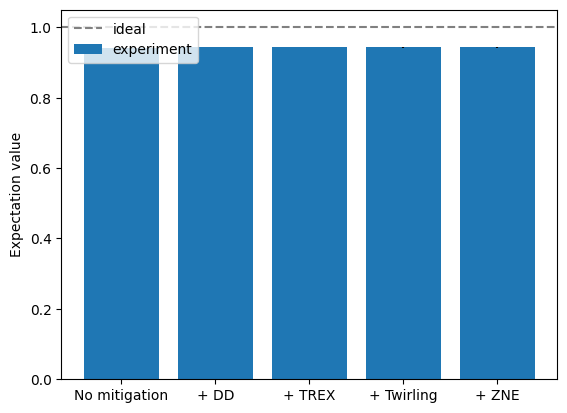

In [31]:
#########################
# CONSTRUCT THE CIRCUIT #
#########################
for n in [10, 20, 30, 40, 50]:
    
n_qubits = 10
reps = 1

# Construct the circuit and observables
circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)
observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=n_qubits)

# Assign parameters to circuit
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)
assigned_circuit = circuit.assign_parameters(params)
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

# Transpile mirror circuit
isa_circuit = pass_manager.run(mirror_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

########################
# RUN IN FAKE PROVIDER #
########################

from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeTorino
import matplotlib.pyplot as plt

backend = FakeTorino()

# Run jobs
pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    # Set number of shots
    estimator.options.default_shots = 100_000
    # Disable runtime compilation and error mitigation
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add dynamical decoupling (DD)
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XpXm"
    job1 = estimator.run([pub])
    jobs.append(job1)

    # Add readout error mitigation (DD + TREX)
    estimator.options.resilience.measure_mitigation = True
    job2 = estimator.run([pub])
    jobs.append(job2)

    # Add gate twirling (DD + TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
    job3 = estimator.run([pub])
    jobs.append(job3)

    # Add zero-noise extrapolation (DD + TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job4 = estimator.run([pub])
    jobs.append(job4)

# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])
standard_errors = np.array([float(pub_result.data.stds) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ DD", "+ TREX", "+ Twirling", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, yerr=standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()